In [2]:
import os
import random
import time
import warnings
from datetime import datetime

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import dblquad
from scipy.interpolate import RectBivariateSpline
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

from dataloader import FastTensorDataLoader

In [3]:
warnings.filterwarnings("ignore", category=UserWarning, module="imageio")

# Data Generation

In [4]:
def generate_poisson_points(kappa, scale, region):
    """
    Generate a Poisson Point Process in a 2D region based on intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as ((xmin, xmax), (ymin, ymax)).
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP.
    """
    (xmin, xmax), (ymin, ymax) = region

    area = (xmax - xmin) * (ymax - ymin)
    max_intensity = kappa * area  # Maximum value of intensity
    num_samples = np.random.poisson(lam=max_intensity)[0]

    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    y_candidates = np.random.uniform(ymin, ymax, size=num_samples)
    candidates = torch.tensor(np.stack([x_candidates, y_candidates], axis=1), dtype=torch.float32)
    
    squared_norm = torch.sum(candidates**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    uniform_samples = torch.rand(num_samples)  # Uniform samples for rejection
    acceptance_mask = uniform_samples < (intensity / kappa)
    
    accepted_points = candidates[acceptance_mask]
    return accepted_points.numpy()

In [5]:
def calculate_integral(sigma, region, intensity=None, intensity_grid=None, grid_x=None, grid_y=None):
    """
    Compute the integral of the intensity function over a region.

    Parameters:
    - sigma: The parameter for the Gaussian function (if using `intensity_function`).
    - region: Tuple ((xmin, xmax), (ymin, ymax)) specifying the region of integration.
    - intensity: Custom intensity function. If provided, this overrides the default Gaussian.
    - intensity_grid: Precomputed intensity values on a grid.
    - grid_x, grid_y: 1D arrays corresponding to `intensity_grid`.

    Returns:
    - The integral of the intensity over the region.
    """
    (xmin, xmax), (ymin, ymax) = region

    def intensity_function(x, y, sigma):
        return np.exp(-(x**2 + y**2) / sigma**2)

    if intensity_grid is not None and grid_x is not None and grid_y is not None:
        # Create an interpolating function for the intensity grid
        interpolator = RectBivariateSpline(grid_x, grid_y, intensity_grid)

        # Define an interpolated intensity function
        def interpolated_intensity(x, y):
            return interpolator(x, y, grid=False)

        # Integrate the interpolated intensity
        integral, _ = dblquad(
            interpolated_intensity,
            xmin, xmax,
            lambda x: ymin, lambda x: ymax
        )
    else:
        # Use the analytical intensity function
        if intensity is not None:
            intensity_function = intensity

        integral, _ = dblquad(
            intensity_function,
            xmin, xmax,
            lambda x: ymin, lambda x: ymax,
            args=(sigma.item(),)
        )

    return integral


def adjust_kappa_for_region(expected_points, sigma, region, intensity_grid=None, grid_x=None, grid_y=None):
    """
    Adjust kappa dynamically for a given region size to maintain expected points.

    Parameters:
    - expected_points: The desired number of points in the region.
    - sigma: The parameter for the Gaussian function (if using `intensity_function`).
    - region: Tuple ((xmin, xmax), (ymin, ymax)) specifying the region of integration.
    - intensity_grid: Precomputed intensity values on a grid.
    - grid_x, grid_y: Grid coordinates corresponding to `intensity_grid`.

    Returns:
    - A tensor containing the adjusted kappa value.
    """
    # Ensure grid_x and grid_y are strictly increasing
    if intensity_grid is not None and grid_x is not None and grid_y is not None:
        # Extract 1D coordinates from the 2D grid
        x_coords = np.unique(grid_x[0])  # Unique x-coordinates (columns of grid_x)
        y_coords = np.unique(grid_y[:, 0])  # Unique y-coordinates (rows of grid_y)

        if len(x_coords) < 2 or len(y_coords) < 2:
            raise ValueError("Insufficient unique points in grid for interpolation.")

        # Compute the integral of the intensity function over the region
        integral = calculate_integral(sigma, region, intensity_grid=intensity_grid, grid_x=x_coords, grid_y=y_coords)
    else:
        integral = calculate_integral(sigma, region)

    # Adjust kappa
    kappa = expected_points / integral
    return torch.tensor([kappa], dtype=torch.float32)




In [6]:
def generate_samples_for_shrinking_region(
    scale, start_region, end_region, steps, expected_points, m
):
    """
    Gradually decreases the area of a region and generates m samples for each subregion.
    
    Parameters:
    - scale (torch.Tensor): Scale parameter for intensity function.
    - start_region (tuple): Starting region as ((xmin, xmax), (ymin, ymax)).
    - end_region (tuple): Ending region as ((xmin, xmax), (ymin, ymax)).
    - steps (int): Number of intermediate steps to divide the shrinking process.
    - expected_points (int): Target number of expected points in each region.
    - m (int): Number of samples to generate for each region.
    
    Returns:
    - region_samples (list): List of m samples for each region.
    - regions (list): List of regions for which samples were generated.
    - avg_points_per_region (list): List of average points per region for m samples.
    - kappas (list): List of kappa values for each region.
    """
    region_samples = []
    regions = []
    avg_points_per_region = []
    kappa_real = []
    
    for step in range(steps + 1):
        # Interpolate region boundaries
        t = step / steps
        xmin = start_region[0][0] * (1 - t) + end_region[0][0] * t
        xmax = start_region[0][1] * (1 - t) + end_region[0][1] * t
        ymin = start_region[1][0] * (1 - t) + end_region[1][0] * t
        ymax = start_region[1][1] * (1 - t) + end_region[1][1] * t
        current_region = ((xmin, xmax), (ymin, ymax))
        
        # Adjust kappa dynamically for the new region
        current_kappa = adjust_kappa_for_region(expected_points, scale, current_region)
        kappa_real.append(current_kappa)
        
        # Generate m Poisson point samples for the current region
        samples = []
        while len(samples) < m:
            sample = generate_poisson_points(current_kappa, scale, current_region)
            samples.append(torch.tensor(sample, dtype=torch.float32))
        
        # Calculate average number of points per sample
        avg_points = sum(len(s) for s in samples) / m
        avg_points_per_region.append(avg_points)
        
        # Save the results
        region_samples.append(samples[:m])  # Ensure exactly m samples
        regions.append(current_region)
        
        print(f"Region {step + 1}: {current_region}, Average Points: {avg_points:.2f}, Kappa: {current_kappa.item()}")
    
    return region_samples, regions, avg_points_per_region, kappa_real


In [7]:
start_region = ((-1, 1), (-1, 1))
end_region = ((0, 1), (0, 1))
steps = 4
expected_points = 100
m = 100  # Number of samples per region
scale = torch.tensor([0.5])

region_samples, regions, avg_points_per_region, kappa_real = generate_samples_for_shrinking_region(
    scale, start_region, end_region, steps, expected_points, m
)


Region 1: ((-1.0, 1.0), (-1.0, 1.0)), Average Points: 100.38, Kappa: 128.52354431152344
Region 2: ((-0.75, 1.0), (-0.75, 1.0)), Average Points: 99.68, Kappa: 132.38099670410156
Region 3: ((-0.5, 1.0), (-0.5, 1.0)), Average Points: 100.09, Kappa: 150.75376892089844
Region 4: ((-0.25, 1.0), (-0.25, 1.0)), Average Points: 99.80, Kappa: 221.6529998779297
Region 5: ((0.0, 1.0), (0.0, 1.0)), Average Points: 98.93, Kappa: 514.0941772460938


## Data Loader

In [8]:
def create_loaders_for_samples(region_samples, batch_size=32, train_ratio=0.8):
    """
    Create loaders for training, validation, and test sets from generated region samples.
    
    Parameters:
    - region_samples (list of numpy arrays): Generated samples for each region.
    - batch_size (int): Batch size for the data loaders.
    - train_ratio (float): Proportion of samples to use for training.
    
    Returns:
    - loaders (list of tuples): A list where each element corresponds to a region and contains:
        (loader_train, loader_test).
    """
    loaders = []
    
    for samples in region_samples:
        samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]
        X = pad_sequence(samples_torch, batch_first=True, padding_value=0)
        
        lengths = torch.tensor([len(s) for s in samples_torch], dtype=torch.int64)
        lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
        X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)
        
        m = len(X)
        train_size = int(train_ratio * m)
        
        X_train = X[:train_size]
        X_test = X[train_size:]
        
        loader_train = FastTensorDataLoader(X_train, batch_size=batch_size, shuffle=True)
        loader_test = FastTensorDataLoader(X_test, batch_size=batch_size, shuffle=False)
        
        loaders.append((loader_train, loader_test))
    
    return loaders


In [9]:
loaders_per_region = create_loaders_for_samples(region_samples)

# Access loaders for a specific region
for i, (loader_train, loader_test) in enumerate(loaders_per_region):
    print(f"Region {i + 1}:")
    print(f"  Training batches: {len(loader_train)}")
    print(f"  Test batches: {len(loader_test)}")

Region 1:
  Training batches: 3
  Test batches: 1
Region 2:
  Training batches: 3
  Test batches: 1
Region 3:
  Training batches: 3
  Test batches: 1
Region 4:
  Training batches: 3
  Test batches: 1
Region 5:
  Training batches: 3
  Test batches: 1


C:\Users\79217\AppData\Local\Temp\ipykernel_23112\2907880100.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]


# Neural Network Poisson Model


In [10]:
def optimize_nn(
        loader_train, nn_model, num_epochs=1000, learning_rate=1e-3, patience=10, weighting=True):
    """
    Optimizes the model parameters, computes validation loss, and implements early stopping.

    Args:
        loader_train (DataLoader): DataLoader for training data.
        loader_val (DataLoader): DataLoader for validation data.
        nn_model (callable): Function that creates the neural network model.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.
        patience (int): Number of epochs to wait before early stopping.

    Returns:
        tuple: (trained model, train_losses, val_losses)
    """
    def initialize_model_and_optimizer():
        model = nn_model()
        sample_input = next(iter(loader_train))[0][:,:,:-1].float() # without length dimension
        model(sample_input)  # Forward pass to initialize the layers
        optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
        return model, optimizer

    def run_epoch(loader, model, weighting, optimizer=None, total_samples=None):
        mode = model.train
        mode()

        loss_sum = 0.0

        for X_batch in loader:
            x_data = X_batch[0]
            if not isinstance(x_data, torch.Tensor):
                x_data = torch.tensor(x_data, dtype=torch.float32)
            optimizer.zero_grad()

            x_data = x_data.clone().detach().requires_grad_()

            loss = model.loss(x_data, weighting=weighting)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() # * len(x_data)
            # Check for NaN gradients
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if torch.isnan(param.grad).any():
                        print(f"NaN in gradients of {name}")
                        break

        return loss_sum / total_samples if total_samples > 0 else 0.0



    def save_model_checkpoint(model, file_path):
        torch.save(model.state_dict(), file_path)

    def load_model_checkpoint(model, file_path):
        model.load_state_dict(torch.load(file_path, weights_only=True))

    model, optimizer = initialize_model_and_optimizer()
    train_losses, val_losses = [], []
    best_train_loss = float('inf')
    epochs_without_improvement = 0

    train_samples = len(loader_train)

    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    for epoch in pbar:
        start_time = time.time()

        # Training phase
        avg_train_loss = run_epoch(loader_train, model, weighting, optimizer, total_samples=train_samples)
        train_losses.append(avg_train_loss)

        # Early stopping and checkpointing
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            epochs_without_improvement = 0
            save_model_checkpoint(model, 'best_model.pt')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        elapsed_time = time.time() - start_time
        pbar.set_postfix({
            "Train Loss": f"{avg_train_loss:.4f}",
            "Time/Epoch": f"{elapsed_time:.2f}s"
        })

    load_model_checkpoint(model, 'best_model.pt')
    return model, train_losses

In [93]:
class Poisson_NN(nn.Module):
    def __init__(self, input_dim=None, hidden_dim=64, output_dim=1):
        super().__init__()
        torch.manual_seed(123)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.input_dim = input_dim  # Initially None, determined dynamically
        self.m = 2
        self.n = 5
        self.p = 0.1

        # Placeholders for layers; they will be initialized once input_dim is set
        self.fc1 = None
        self.fc2 = None

    def initialize_layers(self, input_dim):
        """Initialize layers based on input_dim."""
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='tanh')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='linear')

    def plot_beta(self, x, x_scaled):
        y = self.rescaled_bump_function(x)[0]
        y_original = self.bump_function(x_scaled)[0]
        plt.scatter(x[0][:, 0], y[:, 0], marker=".", label="Rescaled Beta PDF")
        plt.hist(x[0], bins=50, density=True, alpha=0.5, color="orange", label="Histogram of Data")
        plt.legend()
        plt.show()

        plt.scatter(x_scaled[0][:, 0], y_original[:, 0], marker=".", label="Original Beta PDF")
        plt.hist(x_scaled[0], bins=50, density=True, alpha=0.5, color="green", label="Histogram of Scaled Data")
        plt.legend()
        plt.show()

    def forward(self, x):
        if self.fc1 is None or self.fc2 is None:
            self.initialize_layers(x.shape[-1])
            self.max_val = x.max(dim=1, keepdim=True).values
            self.min_val = x.min(dim=1, keepdim=True).values

            scaled_x = (x - self.min_val) / (self.max_val - self.min_val)

            # self.plot_beta(x, scaled_x)

        x = torch.tanh(self.fc1(x))
        intensity = torch.exp(self.fc2(x))
        # intensity = torch.exp(self.fc2(x)) / (1 + torch.exp(self.fc2(x)))
        return intensity

    def compute_psi(self, x):
        x.requires_grad_(True)
        intensity = self.forward(x)
        nn_output = torch.log1p(intensity)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi, intensity

    def bump_function(self, x):
        # Smooth bump function exp(-1 / (x(1-x))^p) for 0 < x < 1, else 0
        x = torch.clamp(x, min=1e-5, max=1 - 1e-5)
        mask = ((x > 0) & (x < 1)).float()
        bump = torch.exp(-1 / ((x * (1 - x)) ** self.p)) * mask

        return bump / bump.max()

    def rescaled_bump_function(self, x):
        # Rescale x to fit within [0, 1] and apply bump function
        self.max_val = x.max(dim=1, keepdim=True).values
        self.min_val = x.min(dim=1, keepdim=True).values

        scaled_x = (x - self.min_val) / (self.max_val - self.min_val)  # Scale to [0, 1]
        bump = self.bump_function(scaled_x)
        return bump #/ (self.max_val - self.min_val)

    def bump_derivative(self, x):
        # Compute derivative of the bump function
        x = torch.clamp(x, min=1e-5, max=1 - 1e-5)
        mask = ((x > 0) & (x < 1)).float()
        denominator = (x * (1 - x)) ** (self.p + 1)
        derivative = (self.p * (1 - 2 * x) / denominator) * torch.exp(-1 / ((x * (1 - x)) ** self.p)) * mask

        return derivative / derivative.max()

    # def beta_function(self, m, n):
    #     return torch.lgamma(torch.tensor(m)) + torch.lgamma(torch.tensor(n)) - torch.lgamma(torch.tensor(m + n))

    # def bump_function(self, x):
    #     x = torch.clamp(x, min=1e-5, max=1 - 1e-5)
    #     B_mn = torch.exp(self.beta_function(self.m, self.n))
    #     return (x ** (self.m - 1) * (1 - x) ** (self.n - 1)) / B_mn

    # def rescaled_bump_function(self, x):
    #     self.max_val = x.max(dim=1, keepdim=True).values
    #     self.min_val = x.min(dim=1, keepdim=True).values

    #     scaled_x = (x - self.min_val) / (self.max_val - self.min_val)
    #     pdf = self.bump_function(scaled_x)
    #     return pdf / (self.max_val - self.min_val)

    # def bump_derivative(self, x):
    #     """Computes the derivative of the Beta probability density function on the rescaled domain."""
    #     x = torch.clamp(x, min=self.min_val + 1e-5, max=self.max_val - 1e-5)
    #     scaled_x = (x - self.min_val) / (self.max_val - self.min_val)
    #     beta_pdf_x = self.bump_function(scaled_x)
    #     term1 = (self.m - 1) / scaled_x
    #     term2 = -(self.n - 1) / (1 - scaled_x)
    #     derivative = beta_pdf_x * (term1 + term2)
    #     return derivative / (self.max_val - self.min_val)

    def loss(self, points, weighting=True):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch

        # Create mask to remove padding
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        psi_x, intensity = self.compute_psi(x_t)

        if weighting:
            h = self.rescaled_bump_function(x_t)
            grad_h = self.bump_derivative(x_t)
            weight = (psi_x * grad_h).sum(dim=-1)
        else:
            h = torch.ones_like(x_t)
            weight = 0

        norm_squared = (psi_x ** 2 * h).sum(dim=-1)  # Sum across all dimensions

        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i] * h[..., i]

        divergence = divergence * mask
        norm_squared = norm_squared * mask
        weight = weight * mask

        total_loss = 0.5 * norm_squared + divergence + weight + (intensity**2).sum(dim=-1)
        total_loss = total_loss.sum(dim=-1)/lengths  # Sum over the time dimension

        batch_size = points.size(0)
        total_loss = total_loss.mean() / batch_size

        return total_loss


In [94]:
def save_model_checkpoint(model, file_path):
    """Save model state and input dimension."""
    torch.save({
        'state_dict': model.state_dict(),
        'input_dim': model.input_dim
    }, file_path)

def load_model_checkpoint(model_class, file_path):
    """Load model state and input dimension."""
    checkpoint = torch.load(file_path, weights_only=True)
    input_dim = checkpoint['input_dim']
    model = model_class(input_dim=input_dim)  # Initialize with input_dim
    model.initialize_layers(input_dim)  # Explicitly initialize layers
    model.load_state_dict(checkpoint['state_dict'])  # Load the state_dict
    return model

In [95]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

In [96]:
os.makedirs("outputs", exist_ok=True)
base_dir = f"outputs/output_{timestamp}"
dirs = {
    "saved_models": f"{base_dir}/saved_models",
    "loss_plots": f"{base_dir}/loss_plots",
    "density_plots": f"{base_dir}/density_plots",
    "difference_plots": f"{base_dir}/difference_plots",
    "videos": f"{base_dir}/videos",
    "metrics": f"{base_dir}/metrics",
}

for path in dirs.values():
    os.makedirs(path, exist_ok=True)

In [97]:
loss_video_path = f"{dirs['videos']}/loss_plots_video.mp4"

torch.autograd.set_detect_anomaly(True)
epochs = 100
learning_rate = 1e-4

region_mse = []
region_r2 = []
loss_plot_files = [] 

In [98]:
def calculate_score_matching_difference(intensity_real, intensity_pred):
    """
    Calculate the Score Matching Difference (SMD) between the real and predicted intensities.

    Parameters:
    - intensity_real: Flattened array of real intensity values.
    - intensity_pred: Flattened array of predicted intensity values.

    Returns:
    - float: Score Matching Difference.
    """
    # Ensure inputs are numpy arrays
    intensity_real = np.asarray(intensity_real)
    intensity_pred = np.asarray(intensity_pred)
    
    # Compute the gradient of the log intensities
    gradient_real = np.gradient(np.log(intensity_real))
    gradient_pred = np.gradient(np.log(intensity_pred))
    
    return np.sum((gradient_real - gradient_pred) ** 2)


def generate_grid(data, num_points=100):
    """
    Generate a 2D grid of points covering the range of the input data.

    Parameters:
    - data (torch.Tensor): Input data tensor of shape (batch_size, sequence_length, 2).
    - num_points (int): Number of points per axis for the grid.

    Returns:
    - numpy.ndarray: A 2D grid of points as an array of shape (num_points^2, 2).
    """
    x_min, x_max = data[:, :, 0].min().item(), data[:, :, 0].max().item()
    y_min, y_max = data[:, :, 1].min().item(), data[:, :, 1].max().item()

    x_lin = np.linspace(x_min, x_max, num_points)
    y_lin = np.linspace(y_min, y_max, num_points)
    x_grid, y_grid = np.meshgrid(x_lin, y_lin)

    grid_points = np.stack([x_grid.ravel(), y_grid.ravel()], axis=1)
    return grid_points, x_grid, y_grid


def calculate_intensity(grid_points, kappa, scale):
    """
    Calculate the real intensity values based on a Gaussian-like function.

    Parameters:
    - grid_points (numpy.ndarray): Grid points as an array of shape (num_points^2, 2).
    - kappa (float): Scaling factor for intensity.
    - scale (float): Scale parameter for the Gaussian function.

    Returns:
    - numpy.ndarray: Real intensity values of shape (num_points, num_points).
    """
    # Compute the squared norm of each point
    squared_norm = np.sum(grid_points**2, axis=-1)
    
    # Calculate the real intensity using a Gaussian-like formula
    intensity = kappa * np.exp(-squared_norm / scale**2)
    intensity = intensity.reshape(int(np.sqrt(grid_points.shape[0])), -1)  # Reshape to grid
    
    # Normalize the intensity
    # intensity /= np.max(intensity)
    return intensity


In [99]:
region_smd = []
kappas_real, kappas_pred = [], []
for region_idx, (loader_train, loader_test) in enumerate(loaders_per_region):
    # Train and save the model
    model, train_losses = optimize_nn(
        loader_train, Poisson_NN, num_epochs=epochs, learning_rate=learning_rate
    )
    model_path = f"{dirs['saved_models']}/region_{region_idx + 1}_model.pth"
    save_model_checkpoint(model, model_path)
    print(f"Model for Region {region_idx + 1} saved at {model_path}")
    
    # Plot training and validation losses
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Region {region_idx + 1}: Score Matching Losses over Epochs')
    plt.legend()
    plt.grid(True)
    
    plot_path = f"{dirs['loss_plots']}/region_{region_idx + 1}_loss.png"
    plt.savefig(plot_path)
    loss_plot_files.append(plot_path)  # Save path for video creation
    plt.close()
    
    # Load the model for evaluation
    model = load_model_checkpoint(Poisson_NN, model_path)
    model.eval()  # Set to evaluation mode
   
    
    smd_list = []
    for batch in loader_test:
        x_test = batch[0][:, :, :2]

        # Determine region bounds
        x_min, x_max = x_test[:, :, 0].min().item(), x_test[:, :, 0].max().item()
        y_min, y_max = x_test[:, :, 1].min().item(), x_test[:, :, 1].max().item()
        region = ((x_min, x_max), (y_min, y_max))
        
        # Generate grid points for evaluation
        grid_points, x_grid, y_grid = generate_grid(x_test)
        kappa_real = adjust_kappa_for_region(expected_points, scale, region)
        kappas_real.append(kappa_real)
        
        # Calculate real intensity
        intensity_real = calculate_intensity(grid_points, kappa_real.item(), scale.item())
        
        # Predict intensity using the model
        intensity_pred = model(torch.tensor(grid_points, dtype=torch.float32)).squeeze().detach().numpy()
        intensity_pred = intensity_pred.reshape(100, 100)
        # intensity_pred /= np.max(intensity_pred)


        # Calculate kappa dynamically
        kappa_pred = adjust_kappa_for_region(
            expected_points,
            scale,
            region,
            intensity_grid=intensity_pred,
            grid_x=x_grid,  # Pass the entire x_grid
            grid_y=y_grid   # Pass the entire y_grid
        )
        kappas_pred.append(kappa_pred)
        
        # Calculate Score Matching Difference
        smd = calculate_score_matching_difference(intensity_real.ravel(), intensity_pred.ravel())
        smd_list.append(smd)
    
    # Calculate average SMD for the region
    average_smd = np.mean(smd_list)
    
    print(f"Region {region_idx + 1}:")
    print(f"  Average Score Matching Difference: {average_smd}")
    
    # Store results for further analysis
    region_smd.append(average_smd)


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training:  46%|████▌     | 46/100 [00:49<00:58,  1.08s/epoch, Train Loss=-0.0486, Time/Epoch=0.85s]

Early stopping at epoch 47
Model for Region 1 saved at outputs/output_20250219_085924/saved_models/region_1_model.pth


Region 1:
  Average Score Matching Difference: 47.500283721605655


Training:  74%|███████▍  | 74/100 [01:07<00:23,  1.10epoch/s, Train Loss=-0.0637, Time/Epoch=0.90s]

Early stopping at epoch 75
Model for Region 2 saved at outputs/output_20250219_085924/saved_models/region_2_model.pth


Region 2:
  Average Score Matching Difference: 99.0899060483008


Training: 100%|██████████| 100/100 [02:01<00:00,  1.22s/epoch, Train Loss=-0.1751, Time/Epoch=1.66s]


Model for Region 3 saved at outputs/output_20250219_085924/saved_models/region_3_model.pth
Region 3:
  Average Score Matching Difference: 166.73463193356082


Training: 100%|██████████| 100/100 [02:40<00:00,  1.60s/epoch, Train Loss=-0.8413, Time/Epoch=0.99s]


Model for Region 4 saved at outputs/output_20250219_085924/saved_models/region_4_model.pth
Region 4:
  Average Score Matching Difference: 269.4228609159994


Training: 100%|██████████| 100/100 [01:38<00:00,  1.01epoch/s, Train Loss=-727.6971, Time/Epoch=1.03s]


Model for Region 5 saved at outputs/output_20250219_085924/saved_models/region_5_model.pth
Region 5:
  Average Score Matching Difference: 717.0708876382564


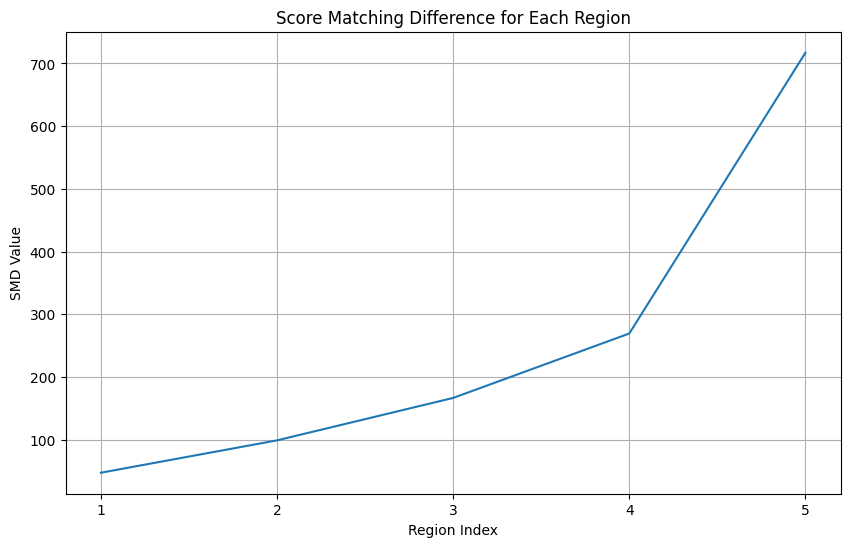

SMD plot saved at: outputs/output_20250219_085924/metrics/region_smd_20250219_085924.png
SMD info saved in: outputs/output_20250219_085924/metrics/smd_info_20250219_085924.txt


In [100]:
plt.figure(figsize=(10, 6))

region_indices = range(1, len(regions) + 1)  # X-axis values: Region indices
plt.plot(region_indices, region_smd, linestyle='-')

# Add labels, title, and legend
plt.xlabel("Region Index")
plt.ylabel("SMD Value")
plt.title("Score Matching Difference for Each Region")
plt.xticks(region_indices)  # Ensure region indices are shown as x-ticks
plt.grid(True)

# Save the plot
plot_file = f"{dirs['metrics']}/region_smd_{timestamp}.png"
plt.savefig(plot_file)
plt.show()

# Save smd details to a text file
kappa_info_file = f"{dirs['metrics']}/smd_info_{timestamp}.txt"
with open(kappa_info_file, "w") as file:
    for i, reg in enumerate(regions):
        file.write(f"Region {i + 1}: {reg}\n")
        file.write(f"SMD: {region_smd[i]:.4f}\n\n")

print(f"SMD plot saved at: {plot_file}")
print(f"SMD info saved in: {kappa_info_file}")

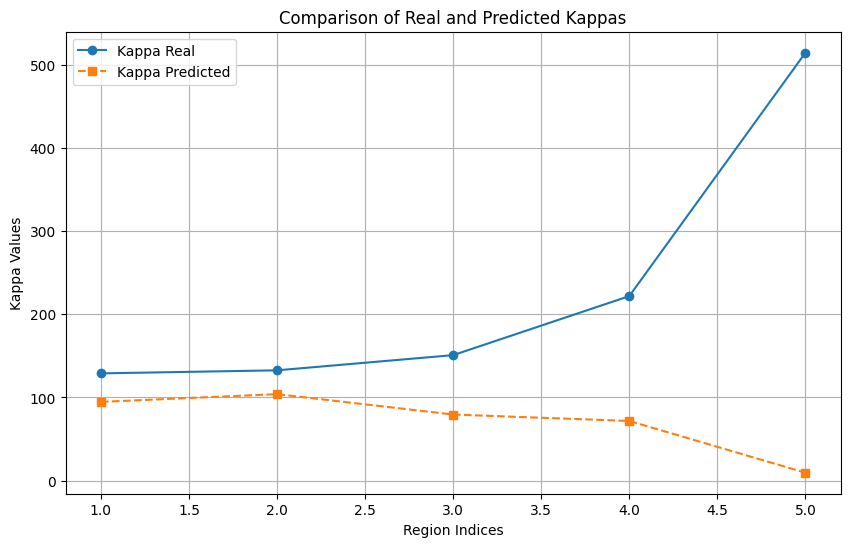

Kappa plot saved at: outputs/output_20250219_085924/metrics/kappas_20250219_085924.png


In [101]:
region_indices = range(1, len(regions) + 1)  # X-axis values: Region indices
plt.figure(figsize=(10, 6))

plt.plot(region_indices, kappas_real, label="Kappa Real", marker="o", linestyle="-")
plt.plot(region_indices, kappas_pred, label="Kappa Predicted", marker="s", linestyle="--")

plt.title("Comparison of Real and Predicted Kappas")
plt.xlabel("Region Indices")
plt.ylabel("Kappa Values")
plt.legend()
plt.grid(True)

# Save the plot
plot_file = f"{dirs['metrics']}/kappas_{timestamp}.png"
plt.savefig(plot_file)
plt.show()

# Save kappa details to a text file
kappa_info_file = f"{dirs['metrics']}/kappa_info_{timestamp}.txt"
with open(kappa_info_file, "w") as file:
    for i, reg in enumerate(regions):
        file.write(f"Region {i + 1}: {reg}\n")
        file.write(f"Kappa Real: {kappas_real[i].item():.4f}\n")
        file.write(f"Kappa Predicted: {kappas_pred[i].item():.4f}\n\n")

print(f"Kappa plot saved at: {plot_file}")

In [102]:
# Create video from saved loss plots
print("Creating video from loss plots...")
with imageio.get_writer(loss_video_path, fps=2) as writer:
    for plot_file in tqdm(loss_plot_files, desc="Writing video"):
        img = imageio.imread(plot_file)
        writer.append_data(img)

print(f"Loss plots video saved at {loss_video_path}")

Creating video from loss plots...


Writing video: 100%|██████████| 5/5 [00:00<00:00, 15.64it/s]


Loss plots video saved at outputs/output_20250219_085924/videos/loss_plots_video.mp4


In [103]:
def get_random_sample_per_region(loaders_test):
    """
    Extracts a random sample for each region from its corresponding test loader.
    
    Parameters:
    - loaders_test (list): List of test loaders, one per region.
    
    Returns:
    - random_samples_per_region (list): List of random samples, one for each region.
    """
    random_samples_per_region = []
    
    for loader_test in loaders_test:
        all_samples = []
        for batch in loader_test:
            all_samples.append(batch[0])  # Assuming the first element contains the data
        
        all_samples = torch.cat(all_samples, dim=0)
        
        random_idx = random.randint(0, all_samples.shape[0] - 1)
        random_sample = all_samples[random_idx]
        random_samples_per_region.append(random_sample)
    
    return random_samples_per_region

In [104]:
intensity_video_path = f"{dirs['videos']}/intensity_visualization.mp4"
density_frame_files = []
difference_video_path = f"{dirs['videos']}/difference_visualization.mp4"
difference_frame_files = []
model_dir = f"saved_models/saved_models_{timestamp}"
random_samples_per_region = get_random_sample_per_region([loader_test for _, loader_test in loaders_per_region])

In [105]:
for region_idx, random_sample in enumerate(tqdm(random_samples_per_region, desc="Regions")):
    model_path = f"{dirs['saved_models']}/region_{region_idx + 1}_model.pth"
    model = load_model_checkpoint(Poisson_NN, model_path)
    model.eval()

    x = random_sample[:, 0].numpy()
    y = random_sample[:, 1].numpy()
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    x_lin = np.linspace(x_min, x_max, 100)
    y_lin = np.linspace(y_min, y_max, 100)
    xx, yy = np.meshgrid(x_lin, y_lin)

    grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
    intensity_pred = model(torch.tensor(grid_points, dtype=torch.float32)).detach().numpy()
    intensity_pred_2d = intensity_pred.reshape(xx.shape)
        
    # Use kappa from kappas_real
    kappa = kappas_real[region_idx].item()  # Ensure kappa is converted to a scalar
    
    intensity_real = kappa * np.exp(-(xx**2 + yy**2) / scale**2)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Model-predicted intensity
    c1 = axs[0].contourf(
        xx, yy, intensity_pred_2d, levels=50,
        cmap='viridis', alpha=0.8, # vmin=0, vmax=1
    )
    axs[0].scatter(x, y, c='red', s=5, alpha=0.6, label='Poisson Points')
    axs[0].set_title(r'Predicted Intensity $\rho(x)$', fontsize=16)
    axs[0].set_xlabel(r'$x$', fontsize=14)
    axs[0].set_ylabel(r'$y$', fontsize=14)
    axs[0].legend()
    axs[0].set_aspect('equal')
    axs[0].grid(True, linestyle='--', alpha=0.5)
    fig.colorbar(c1, ax=axs[0], label="Normalized Intensity")

    # Plot 2: True intensity
    if isinstance(intensity_real, torch.Tensor):
        intensity_real = intensity_real.numpy()
    c2 = axs[1].contourf(
        xx, yy, intensity_real, levels=50,
        cmap='viridis', alpha=0.7, # vmin=0, vmax=1
    )
    axs[1].scatter(x, y, c='red', s=5, alpha=0.6, label='Poisson Points')
    axs[1].set_title('True Intensity', fontsize=16)
    axs[1].set_xlabel(r'$x$', fontsize=14)
    axs[1].set_ylabel(r'$y$', fontsize=14)
    axs[1].legend()
    axs[1].set_aspect('equal')
    axs[1].grid(True, linestyle='--', alpha=0.5)
    fig.colorbar(c2, ax=axs[1], label="Normalized Intensity")

    plt.tight_layout()
    
    frame_file_density = f"{dirs['density_plots']}/region_{region_idx + 1}.png"
    plt.savefig(frame_file_density)
    density_frame_files.append(frame_file_density)
    plt.close(fig)

    # Plot 3: Difference
    difference = (intensity_pred_2d / np.max(intensity_pred_2d)) - (intensity_real / np.max(intensity_real))

    plt.figure(figsize=(10, 8))
    contour = plt.contourf(
        xx, yy, difference, levels=50, cmap='viridis', alpha=0.8, vmin=-1, vmax=1
    )
    plt.title(r'Region {}: Difference $\rho(x)$ - Poisson'.format(region_idx + 1), fontsize=16)
    plt.xlabel(r'$x$', fontsize=14)
    plt.ylabel(r'$y$', fontsize=14)
    plt.scatter(x, y, c='red', s=5, alpha=0.6, label='Poisson Points')
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.colorbar(contour, label="Difference")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    frame_file_difference = f"{dirs['difference_plots']}/region_{region_idx + 1}_difference.png"
    plt.savefig(frame_file_difference)
    difference_frame_files.append(frame_file_difference)
    plt.close()


Regions:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\79217\AppData\Local\Temp\ipykernel_23112\1446724201.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  intensity_real = kappa * np.exp(-(xx**2 + yy**2) / scale**2)
Regions: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


In [106]:
print("Creating density video...")
with imageio.get_writer(intensity_video_path, fps=2) as writer:
    for frame_file in tqdm(density_frame_files, desc="Writing video"):
        writer.append_data(imageio.imread(frame_file))

Creating density video...


Writing video: 100%|██████████| 5/5 [00:00<00:00, 10.24it/s]


In [107]:
print("Creating difference video...")
with imageio.get_writer(difference_video_path, fps=2) as writer:
    for frame_file in tqdm(difference_frame_files, desc="Writing video"):
        writer.append_data(imageio.imread(frame_file))

Creating difference video...


Writing video: 100%|██████████| 5/5 [00:00<00:00, 14.15it/s]
